In [7]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
from fancy_round import fancy_round
from wb_api_wrapper import *
import numpy as np
import pandas as pd


### Data from WDI

In [9]:
groups = pd.read_csv("income_groups.csv",header =4,index_col=["Economy"], na_values="..", usecols=["Economy","Lending category"] )
wb_countries=groups.dropna().index

In [14]:
data_wb = get_wb("NY.GDP.PCAP.KN")#GDP per capita (constant LCU)
""" NY.GDP.MKTP.KD.ZG real growth ong serie
"NY.GDP.PCAP.PP.CD"  ppp gdp pc short series
NY.GDP.MKTP.KD 
NY.GDP.PCAP.KD""";



### Data from PWT 

In [21]:
iso_to_wb =pd.read_csv('iso3_to_wb_name.csv',index_col="iso3",squeeze=True);

def replace_with_warning(series_in,dico):
    out=series_in.replace(dico)
    bads = [c for c in out if c not in dico.tolist()]
    if bads !=[]:
        warnings.warn("\nbad country names : "+",".join(bads))
    return out

if False:
    #Data on real GDP per capita. Ends in 2002
    pwt = pd.read_csv("FebPwtExport11172015.csv").drop("VariableCode",axis=1).rename(columns={"YearCode":"year"})
    pwt["country"] = replace_with_warning(pwt["RegionCode"],iso_to_wb)

    #pivots data
    hop=pwt.set_index(["country"])[["year","AggValue"]]
    data_pwt=hop.pivot(columns="year",values="AggValue")

else:
    #Data on pop and reald gdp PPP. Ends in 2010
    pwt= pd.read_csv("pwt_rgdpe_pop_8.1.csv").rename(columns={"YearCode":"year"})
    pwt["country"] = replace_with_warning(pwt["RegionCode"],iso_to_wb)

    gdp=pwt.set_index(["country"]).query("VariableCode=='rgdpe'")[["year","AggValue"]].pivot(columns="year",values="AggValue")
    pop=pwt.set_index(["country"]).query("VariableCode=='pop'")[["year","AggValue"]].pivot(columns="year",values="AggValue")
    data_pwt=gdp/pop


# Process the data

Series([], Name: year, dtype: float64)


count    142.000000
mean       1.914439
std        2.354708
min       -6.259178
25%        0.609807
50%        1.599204
75%        2.969416
max       10.780995
Name: 0, dtype: float64
Series([], Name: year, dtype: float64)


count    118.000000
mean       2.937205
std        3.158551
min       -5.734340
25%        1.140960
50%        2.798386
75%        4.735227
max       12.817878
Name: 0, dtype: float64


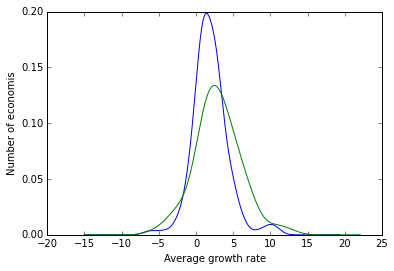

In [22]:
#histograms 
for data_ in [data_wb, data_pwt]:
    data= data_.ix[data_.index.isin(wb_countries)] #Takes only actual countries (filters things like LAC out and developed countries)
    
    
    gdp_now  = mrv(data)
    gdp_then = lrv(data)

    now = mr_year(data).astype('float64')
    then = lr_year(data).astype('float64').clip(lower=now-30)

    pd.DataFrame([then,gdp_then, now, gdp_now],index=["year","GDPpc","year","GDPpc"]).T.to_excel("growth.xlsx")
    growth_rates=(np.power(gdp_then/gdp_now, -1/(now-then))-1)*100

    #removes countries with little data
    print((now-then)[(now-then<4)])
    growth_rates[(now-then<4)]=np.nan


    #Stats
    ax=(1*growth_rates).plot(kind="kde",grid="off")
    ax.set_xlabel("Average growth rate")
    ax.set_ylabel("Number of economis")
    print("\n")
    print((1*growth_rates).describe())
    

In [23]:
### The World econoy as a whole grew less than countries individually on average
data_allcountries = data.dropna(axis=1)
(np.power(data_allcountries[1990].sum()/data_allcountries[2010].sum(), -1/(20))-1)*100

2.4609656206132868

In [24]:
import matplotlib.pylab as plt

C:\Users\Admin\Anaconda3\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


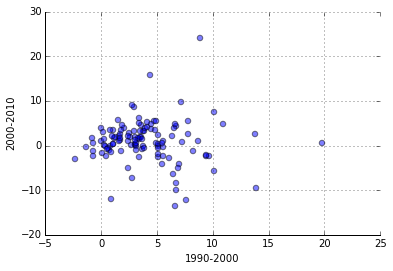

In [25]:
x=old_gr =(np.power(data_allcountries[2000]/data_allcountries[2010], -1/(10))-1)*100
y=new_gr =(np.power(data_allcountries[1990]/data_allcountries[2000], -1/(10))-1)*100
names_=x.index

ax=plt.subplot(1,1,1)
ax.scatter(old_gr,new_gr, s=30, alpha=0.5)

#ax.spines['bottom'].set_position("bottom")
ax.spines['right'].set_color('none')

ax.spines['top'].set_color('none')
#ax.spines['left'].set_position("left")

ax.grid("on")

ax.set_xlabel("1990-2000")
ax.set_ylabel("2000-2010")

logical = False &( (old_gr<0 )| (old_gr>10) | (new_gr>10) | (new_gr<0) )
for label, x_, y_ in zip(names_[logical], x[logical], y[logical]):
    plt.annotate(
        label, 
        xy = (x_, y_), xytext = (10, 0),
        textcoords = 'offset points', ha = 'left', va = 'center',fontsize=13
        #bbox = nonedict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5),
        #arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0')
    )

    
plt.savefig("growth_rates_scatter.png")

In [27]:
x=pd.DataFrame([then,gdp_then, now,gdp_now],index=["then","gdp_then","now","gdp_now"])
x["Congo, Dem. Rep."]

then        1980.000000
gdp_then     925.367228
now         2010.000000
gdp_now      384.504907
Name: Congo, Dem. Rep., dtype: float64

# Output

In [28]:
g=growth_rates.apply(fancy_round).dropna()
g.to_csv("growth_rates.csv")

g=g.reset_index()


#g.to_csv("list_growth_rates_range.csv",index=None)

#with open("Output.txt", "w") as text_file:
#    text_file.write(", ".join(g))


def arrange_in_n_columns(g,n=3):
    #Arrange over n columns
    for i in np.arange(0,n-np.mod(g.shape[0],n)):
        g.loc[len(g)+1]=" "
    return pd.DataFrame(g.reshape(3,g.shape[0]/n)).T

arrange_in_n_columns(g["country"]+" "+g[0].astype(str)+u"\u2014"+(2*g[0]).astype(str)).to_csv("growth_rates_range_three_columns.csv",header=None,index=None)    

arrange_in_n_columns(g["country"]+" "+(1.5*g[0]).apply(fancy_round).astype(str)).to_csv("growth_rates_15_three_columns.csv",header=None,index=None)  

In [26]:
#Unrelated line to compute discount factors. But mind numerical error, this is better done with analytical resolution
1000*(1/np.power((1.12),np.arange(0,19))).sum() / 1000*(1/np.power((1.12),np.arange(0,100))).sum()


76.995998895671718